In [1]:
# git checkout simplicity_masksL1
import sys,os
sys.path.append('.')
sys.path.append('/home/lev/slot_attention/')
import torch
from typing import Optional
from slot_attention.utils import to_rgb_from_tensor
from torchvision import utils as vutils
import pytorch_lightning.loggers as pl_loggers
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from torchvision import transforms

from slot_attention.utils import to_rgb_from_tensor
from torchvision import utils as vutils
from torch.nn import functional as F
from slot_attention.data import CLEVRDataModule, ESC50DataModule, SyntaticDataModule
from slot_attention.method import SlotAttentionMethod
from slot_attention.model import SlotAttentionModel, Encoder, Decoder
from slot_attention.params import SlotAttentionParams
from slot_attention.utils import ImageLogCallback, assert_shape
from slot_attention.utils import rescale, normalize_audio

from slot_attention.utils import Tensor
from slot_attention.utils import assert_shape
from slot_attention.utils import build_grid
from slot_attention.utils import conv_transpose_out_shape

from hydra import compose, initialize
from omegaconf import OmegaConf
import hydra 
import wandb
from omegaconf import DictConfig, OmegaConf

import logging
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="4"

class SlotAttention_gru(nn.Module):
    def __init__(self, in_features, cfg: DictConfig):
        super().__init__()
        self.epsilon = 1e-8
        self.in_features =in_features
        self.num_iterations = cfg.model.num_iterations
        self.num_slots = cfg.model.num_slots
        self.slot_size = cfg.model.slot_size  # number of hidden layers in slot dimensions
        self.mlp_hidden_size = cfg.model.mlp_hidden_size
        

        self.norm_inputs = nn.LayerNorm(self.in_features)
        # I guess this is layer norm across each slot? should look into this
        self.norm_slots = nn.LayerNorm(self.slot_size)
        self.norm_mlp = nn.LayerNorm(self.slot_size)

        # Linear maps for the attention module.
        self.project_q = nn.Linear(self.slot_size, self.slot_size, bias=False)
        self.project_k = nn.Linear(self.slot_size, self.slot_size, bias=False)
        self.project_v = nn.Linear(self.slot_size, self.slot_size, bias=False)

        # Slot update functions.
        self.gru = nn.GRUCell(self.slot_size, self.slot_size)
        self.mlp = nn.Sequential(
            nn.Linear(self.slot_size, self.mlp_hidden_size),
            nn.ReLU(),
            nn.Linear(self.mlp_hidden_size, self.slot_size),
        )

        self.register_buffer(
            "slots_mu",
            nn.init.xavier_uniform_(torch.zeros((1, 1, self.slot_size)), gain=nn.init.calculate_gain("linear")),
        )
        self.register_buffer(
            "slots_log_sigma",
            nn.init.xavier_uniform_(torch.zeros((1, 1, self.slot_size)), gain=nn.init.calculate_gain("linear")),
        )

    def forward(self, inputs):
        # `inputs` has shape [batch_size, num_inputs, inputs_size].
        batch_size, num_inputs, inputs_size = inputs.shape
        inputs = self.norm_inputs(inputs)  # Apply layer norm to the input.
        k = self.project_k(inputs)  # Shape: [batch_size, num_inputs, slot_size].
        assert_shape(k.size(), (batch_size, num_inputs, self.slot_size))
        v = self.project_v(inputs)  # Shape: [batch_size, num_inputs, slot_size].
        assert_shape(v.size(), (batch_size, num_inputs, self.slot_size))

        # Initialize the slots. Shape: [batch_size, num_slots, slot_size].
        slots_init = torch.randn((batch_size, self.num_slots, self.slot_size))
        slots_init = slots_init.type_as(inputs)
        slots = self.slots_mu + self.slots_log_sigma.exp() * slots_init

        # Multiple rounds of attention.
        for _ in range(self.num_iterations):
            slots_prev = slots
            slots = self.norm_slots(slots)

            # Attention.
            q = self.project_q(slots)  # Shape: [batch_size, num_slots, slot_size].
            assert_shape(q.size(), (batch_size, self.num_slots, self.slot_size))

            attn_norm_factor = self.slot_size ** -0.5
            attn_logits = attn_norm_factor * torch.matmul(k, q.transpose(2, 1))
            attn = F.softmax(attn_logits, dim=-1)
            # `attn` has shape: [batch_size, num_inputs, num_slots].
            assert_shape(attn.size(), (batch_size, num_inputs, self.num_slots))

            # Weighted mean.
            attn = attn + self.epsilon
            attn = attn / torch.sum(attn, dim=1, keepdim=True)
            updates = torch.matmul(attn.transpose(1, 2), v)
            # `updates` has shape: [batch_size, num_slots, slot_size].
            assert_shape(updates.size(), (batch_size, self.num_slots, self.slot_size))

            #Slot update.
            #GRU is expecting inputs of size (N,H) so flatten batch and slots dimension
            slots = self.gru(
                updates.view(batch_size * self.num_slots, self.slot_size),
                slots_prev.view(batch_size * self.num_slots, self.slot_size),
            )
            #slots = self.lam * slots + (1-self.lam)*updates

            slots = slots.view(batch_size, self.num_slots, self.slot_size)
            assert_shape(slots.size(), (batch_size, self.num_slots, self.slot_size))
            slots = slots + self.mlp(self.norm_mlp(slots))
            assert_shape(slots.size(), (batch_size, self.num_slots, self.slot_size))

        return slots

class SlotAttentionModel_gru(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.resolution = cfg.model.resolution
        self.num_slots = cfg.model.num_slots
        self.num_iterations = cfg.model.num_iterations
        self.kernel_size = cfg.model.kernel_size
        self.slot_size = cfg.model.slot_size
        self.empty_cache = cfg.model.empty_cache
        
        # number of channels depend on dataset
        self.in_channels = cfg.dataset.in_channels
        self.hidden_dims = tuple(cfg.model.hidden_dims)
        self.decoder_resolution = tuple(cfg.model.decoder_resolution)

        self.out_features = self.hidden_dims[-1]
        
        # intitialize encoder, decoder, slot attention
        self.encoder = Encoder(cfg=cfg)
        self.decoder = Decoder(cfg=cfg)

        self.slot_attention = SlotAttention_gru(
            in_features=self.out_features,
            cfg = cfg
        )

    def forward(self, x):
        if self.empty_cache:
            torch.cuda.empty_cache()

        batch_size, num_channels, height, width = x.shape
        encoder_out = self.encoder(x)
        slots = self.slot_attention(encoder_out)

        # `slots` has shape: [batch_size, num_slots, slot_size].
        assert_shape(slots.size(), (batch_size, self.num_slots, self.slot_size))
        batch_size, num_slots, slot_size = slots.shape

        #reshape slots for decoder to produce the copies of the slots
        slots = slots.view(batch_size * num_slots, slot_size, 1, 1)
        #WHY DO WE CREATE 8 by 8 decoder copies
        # decoder_in.size = [batch_size * num_slots, slot_size, decoder_resolution[0], decoder_resolution[1]].
        decoder_in = slots.repeat(1, 1, self.decoder_resolution[0], self.decoder_resolution[1])

        out = self.decoder(decoder_in)
        # `out` has shape: [batch_size*num_slots, num_channels+1, height, width].
        assert_shape(out.size(), (batch_size * num_slots, num_channels + 1, height, width))

        out = out.view(batch_size, num_slots, num_channels + 1, height, width)
        recons = out[:, :, :num_channels, :, :]
        masks = out[:, :, -1:, :, :]
        masks = F.softmax(masks, dim=1)
        recon_combined = torch.sum(recons * masks, dim=1)
        return recon_combined, recons, masks, slots

    def loss_function(self, input):
        recon_combined, recons, masks, slots = self.forward(input)
        batch_size, _, _, _ = recon_combined.shape
        
        slots = slots.view(batch_size, self.num_slots, self.slot_size)
        slot_dist = torch.mean(torch.cdist(slots, slots))
        masks_uns = masks.squeeze(2)
        zeros_perc = torch.mean(torch.sum(masks_uns < 10e-4 ,dim = (1,2,3)).type_as(masks_uns))/(5*128*128)


        L1 = torch.mean(masks_uns.abs().sum(dim=[2,3]))
        L2 = torch.mean(torch.sqrt( (masks_uns**2).sum(dim=[2,3])).sum(dim=1))
        mse = F.mse_loss(recon_combined, input)
        loss = mse + 10e-4*L2 #+ 10e-4*L1
        
        
        return {
            "loss": loss,
            "slot_dist": slot_dist,
            "L2": L2,
            "L1": L1,
            "zeros_perc": zeros_perc

        }


def get_dataset(cfg:DictConfig):
    if "_dataset" in cfg.dataset.name:   
        return SyntaticDataModule(cfg)

    elif cfg.dataset.name == 'esc50':
        clevr_transforms = transforms.Compose(
        [
            transforms.Lambda(normalize_audio)
        ])

        return ESC50DataModule(cfg=cfg, clevr_transforms=clevr_transforms)
    elif cfg.dataset.name == 'clever':
        clevr_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Lambda(rescale),  # rescale between -1 and 1
            transforms.Resize(tuple(cfg.model.resolution)),
        ]

         )

        clevr_datamodule = CLEVRDataModule(
            data_root=cfg.dataset.data_root,
            max_n_objects=cfg.model.num_slots - 1,
            train_batch_size=cfg.dataset.train_batch_size,
            val_batch_size=cfg.dataset.val_batch_size,
            clevr_transforms=clevr_transforms, # change also this moment))
            num_train_images=cfg.dataset.num_train_images,
            num_val_images=cfg.dataset.num_val_images,
            num_workers=cfg.dataset.num_workers,
        )
        return clevr_datamodule
    else: 
        print('Choose the dataset')
        
    




def main_mean(cfg):
    assert cfg.model.num_slots > 1, "Must have at least 2 slots."

    if cfg.additional.is_verbose:
        print(f"INFO: limiting the dataset to only images with `num_slots - 1` ({cfg.model.num_slots - 1}) objects.")
        if cfg.dataset.num_train_images:
            print(f"INFO: restricting the train dataset size to `num_train_images`: {cfg.dataset.num_train_images}")
        if cfg.dataset.num_val_images:
            print(f"INFO: restricting the validation dataset size to `num_val_images`: {cfg.dataset.num_val_images}")

 
    
    clevr_datamodule = get_dataset(cfg)

    print(f"Training set size (images must have {cfg.model.num_slots - 1} objects):", len(clevr_datamodule.train_dataset))

    model = SlotAttentionModel(
        cfg=cfg
    )

    method = SlotAttentionMethod(model=model, datamodule=clevr_datamodule, hparams=cfg)
    return method, clevr_datamodule

def main_gru(cfg):
    assert cfg.model.num_slots > 1, "Must have at least 2 slots."

    if cfg.additional.is_verbose:
        print(f"INFO: limiting the dataset to only images with `num_slots - 1` ({cfg.model.num_slots - 1}) objects.")
        if cfg.dataset.num_train_images:
            print(f"INFO: restricting the train dataset size to `num_train_images`: {cfg.dataset.num_train_images}")
        if cfg.dataset.num_val_images:
            print(f"INFO: restricting the validation dataset size to `num_val_images`: {cfg.dataset.num_val_images}")

 
    
    clevr_datamodule = get_dataset(cfg)

    print(f"Training set size (images must have {cfg.model.num_slots - 1} objects):", len(clevr_datamodule.train_dataset))

    model = SlotAttentionModel_gru(
        cfg=cfg
    )

    method = SlotAttentionMethod(model=model, datamodule=clevr_datamodule, hparams=cfg)
    return method, clevr_datamodule


In [2]:
checkpoint_path_mean_L2 = "/home/lev/slot_attention/outputs/2021-12-09/20-00-00/implicit_experiments/2619mscn/checkpoints/epoch=99-step=27298.ckpt"
checkpoint_path_bechmark ="/home/lev/slot_attention/outputs/2021-12-01/clever_model_100epoch/slot-attention-search/1ci43d71/checkpoints/epoch=99-step=27299.ckpt"

with initialize(config_path="../buffer/configs_benchmark", job_name="test_app"):
    cfg = compose(config_name="/clever_default", overrides=[])
method_gru, clevr_datamodule = main_gru(cfg)

with initialize(config_path="../buffer/configs_MA_L2", job_name="test_app"):
    cfg = compose(config_name="default", overrides=[])
method_mean, clevr_datamodule = main_mean(cfg)


data = torch.load(checkpoint_path_bechmark)
method_gru.load_state_dict(data['state_dict'])

data = torch.load(checkpoint_path_mean_L2)
method_mean.load_state_dict(data['state_dict'])

INFO: limiting the dataset to only images with `num_slots - 1` (4) objects.
INFO: restricting the train dataset size to `num_train_images`: -1
INFO: restricting the validation dataset size to `num_val_images`: -1


/opt/anaconda3/envs/reprodl/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Global seed set to 0


Training set size (images must have 4 objects): 17414
INFO: limiting the dataset to only images with `num_slots - 1` (4) objects.
INFO: restricting the train dataset size to `num_train_images`: -1
INFO: restricting the validation dataset size to `num_val_images`: -1


Global seed set to 0


Training set size (images must have 4 objects): 17414


<All keys matched successfully>

In [6]:
def visualize_mask(method, idx=0,dataset = clevr_datamodule.val_dataset):
    method.to(torch.device('cuda'))
    method.eval()
    for i, batch in enumerate(dataset):
        if i == idx:
            batch = batch.unsqueeze(0).to(torch.device('cuda'))
            break

    recon_combined, recons, masks, slots = method(batch)

    # combine images in a nice way so we can display all outputs in one grid, output rescaled to be between 0 and 1
    # combine images in a nice way so we can display all outputs in one grid, output rescaled to be between 0 and 1
    out = to_rgb_from_tensor(
        torch.cat(
            [
                batch.unsqueeze(1),  # original images
                recon_combined.unsqueeze(1),  # reconstructions
                recons * masks + (1 - masks),  # each slot
            ],
            dim=1,
        )
    )

    batch_size, num_slots, C, H, W = recons.shape
    images = vutils.make_grid(
        out.view(batch_size * out.shape[1], C, H, W).cpu(), normalize=False, nrow=out.shape[1],
    )
    ch, h, w = images.shape
    plt.imshow(images.reshape(h, w, ch))

    data =  masks.squeeze(0).cpu().detach().numpy()

    fig = plt.figure(figsize=(12, 12))
    columns = len(data)
    rows = 1
    
    print(data.shape)
    for idx in range(len(data)):
        fig.add_subplot(rows, columns, idx+1)
        plt.imshow(data[idx, 0], cmap='hot')
        # ax = sns.heatmap(data[idx,0])
       
    plt.colorbar()
    plt.show()

(5, 1, 128, 128)


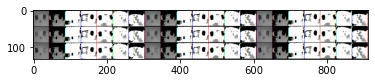

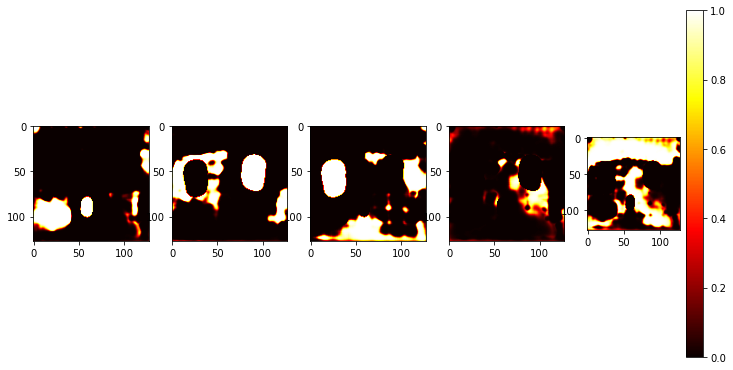

In [7]:
visualize_mask(method_gru)

In [42]:
def sample_images( model, datamodule=clevr_datamodule,):
    dl = datamodule.val_dataloader()
    perm = torch.randperm(64)
    idx = perm[: 3]
    batch = next(iter(dl))[idx]
    
    batch = batch.to(torch.device('cuda'))
    recon_combined, recons, masks, slots = model.forward(batch)

    # combine images in a nice way so we can display all outputs in one grid, output rescaled to be between 0 and 1
    out = to_rgb_from_tensor(
        torch.cat(
            [
                batch.unsqueeze(1),  # original images
                recon_combined.unsqueeze(1),  # reconstructions
                recons * masks + (1 - masks),  # each slot
            ],
            dim=1,
        )
    )
    masks_rep = masks.repeat(1,1,3,1,1)
    out_new = torch.cat([out, masks_rep], dim=1)

    batch_size, num_slots, C, H, W = recons.shape
    images = vutils.make_grid(
        out_new.view(batch_size * out_new.shape[1], C, H, W).cpu(), normalize=False, nrow=out_new.shape[1],
    )

    return images, out, masks

In [43]:
images, out, masks = sample_images(model = method_mean)

In [35]:
out.shape

torch.Size([3, 7, 3, 128, 128])

In [40]:
masks_rep = masks.repeat(1,1,3,1,1)
out_new = torch.cat([out, masks_rep], dim=1)

In [73]:
import numpy as np
np.sqrt(0.09)

0.3

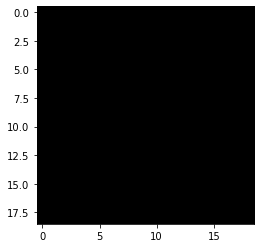

In [83]:
plt.imshow(np.zeros((19,19,3)))

In [147]:
from torchvision import utils as vutils
batch_size, num_slots, C, H, W = masks.shape
images = vutils.make_grid(
        masks.view(batch_size * masks.shape[1], 1, H, W).cpu(), normalize=False, nrow=masks.shape[1],
    )

In [149]:
masks.shape

torch.Size([3, 5, 1, 128, 128])

tensor([[[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.2003, 0.2003, 0.2003],
         ...,
         [0.2002, 0.2002, 0.2002],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.1997, 0.1997, 0.1997],
         ...,
         [0.2002, 0.2002, 0.2002],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.

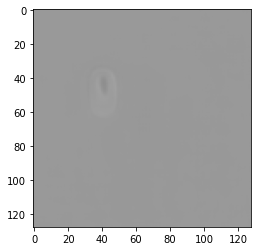

In [150]:
plt.rcParams["savefig.bbox"] = 'tight'
data = masks_rep.permute(0,1,3,4,2).cpu().detach().numpy()[0,2]
plt.imshow(to_rgb_from_tensor(masks_rep).permute(0,1,3,4,2).cpu().detach().numpy()[0,4])
plt.show()

In [61]:
masks_rep.shape

torch.Size([3, 5, 3, 128, 128])

In [60]:
a = torch.rand(1, 2, 3, 4)
print(a.transpose(0, 3).transpose(1, 2).size())
print(a.permute(3, 2, 1, 0).size())

torch.Size([4, 3, 2, 1])
torch.Size([4, 3, 2, 1])


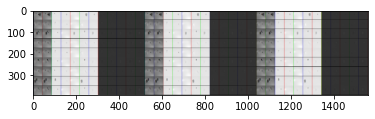

In [46]:
plt.imshow(images.cpu().detach().numpy().reshape( 392, 1562,3 ))

(5, 1, 128, 128)


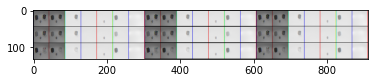

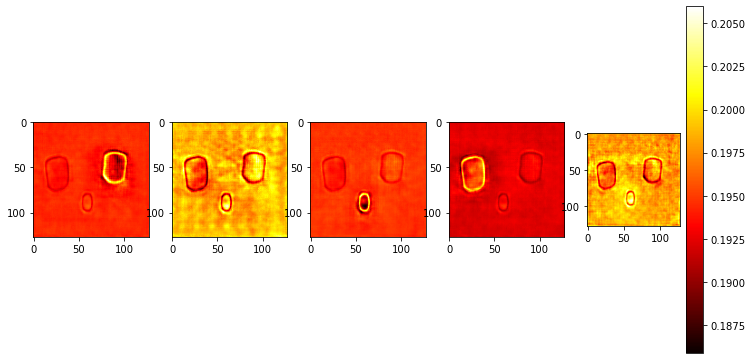

In [8]:
visualize_mask(method_mean)


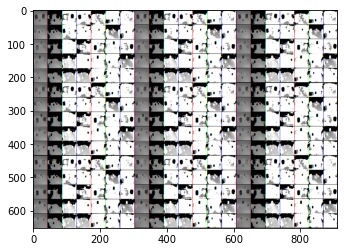

In [158]:


for batch in clevr_datamodule.val_dataloader():

    batch = batch[:5].to(torch.device('cuda'))
    break

recon_combined, recons, masks, slots = method_gru(batch)


from slot_attention.utils import to_rgb_from_tensor
from torchvision import utils as vutils
# combine images in a nice way so we can display all outputs in one grid, output rescaled to be between 0 and 1
out = to_rgb_from_tensor(
    torch.cat(
        [
            batch.unsqueeze(1),  # original images
            recon_combined.unsqueeze(1),  # reconstructions
            recons * masks + (1 - masks),  # each slot
        ],
        dim=1,
    )
)

batch_size, num_slots, C, H, W = recons.shape
images = vutils.make_grid(
    out.view(batch_size * out.shape[1], C, H, W).cpu(), normalize=False, nrow=out.shape[1],
)
ch, h, w = images.shape
plt.imshow(images.reshape(h, w, ch))

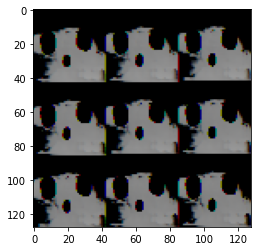

In [149]:
plt.imshow(to_rgb_from_tensor(recon_combined)[0].detach().cpu().numpy().reshape(128,128,-1))

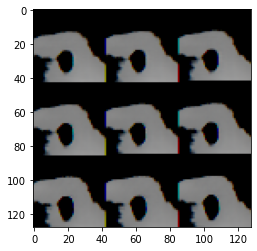

In [166]:
plt.imshow(to_rgb_from_tensor(recons)[0,3].cpu().detach().numpy().reshape(128,128,3))

In [169]:
to_rgb_from_tensor(recons)[0]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6101, 0.6146, 0.6112],
          [0.0000, 0.0000, 0.0000,  ..., 0.6113, 0.6229, 0.6195],
          [0.0000, 0.0000, 0.0000,  ..., 0.6103, 0.6085, 0.6061]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6175, 0.6217, 0.6132],
          [0.0000, 0.0000, 0.0000,  ..., 0.6138, 0.6237, 0.6048],
          [0.0000, 0.0000, 0.0000,  ..., 0.6018, 0.6162, 0.6005]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


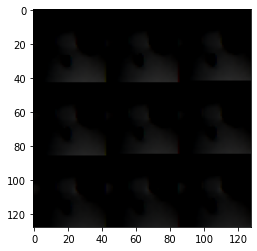

In [138]:
plt.imshow(recon_combined[0].detach().cpu().numpy().reshape(128,128,-1))

In [130]:
recon_combind

tensor([[[[-1.4828e+01, -1.6339e+01, -1.6727e+01,  ..., -1.9474e+01,
           -1.9658e+01, -1.6551e+01],
          [-1.7717e+01, -1.6808e+01, -1.6774e+01,  ..., -1.9651e+01,
           -2.0339e+01, -2.0213e+01],
          [-1.7108e+01, -1.6531e+01, -1.6289e+01,  ..., -1.9889e+01,
           -2.0539e+01, -2.0837e+01],
          ...,
          [-7.4285e+00, -7.7721e+00, -3.8091e+00,  ...,  5.2725e-02,
            5.7871e-02,  8.0426e-02],
          [-7.2663e+00, -8.1674e+00, -7.8324e+00,  ...,  4.8493e-02,
            7.1448e-02,  8.1503e-02],
          [-4.6825e+00, -5.9875e+00, -6.1607e+00,  ...,  5.4850e-02,
            5.8638e-02,  8.9053e-02]],

         [[-1.5050e+01, -1.6900e+01, -1.6669e+01,  ..., -1.9537e+01,
           -1.9062e+01, -1.5972e+01],
          [-1.7764e+01, -1.7387e+01, -1.6370e+01,  ..., -1.9485e+01,
           -1.9175e+01, -1.9149e+01],
          [-1.7512e+01, -1.7016e+01, -1.6047e+01,  ..., -1.9381e+01,
           -1.9560e+01, -2.0341e+01],
          ...,
     